# Finetuning CTC models on Vietnamese language

In this tutorial, we extend previous tutorials and discuss in detail how to * fine-tune a pre-trained model for the Vietnamese language!

This tutorial will dive deeper into essential steps such as: 
- Data preprocessingPrepare tokenizers
- Discuss how to fine-tune models on low-resource languages efficiently
- Train a character encoding CTC model
- Train a sub-word encoding CTC model

For this tutorial (and limited by the compute and storage available on Colab environments), we will attempt to fine-tune an English ASR model onto the Mozilla Common Voice dataset for Vietnamese. 

This dataset will also allow us to discuss a few details for fine-tuning low-resource languages. The methods discussed here can also be applied to languages with several thousand hours of data!Note: It is advised to review the execution flow diagram for ASR models in order to correctly setup the model prior to fine-tuning - ASR CTC Examples

In [ ]:
# Install dependencies

!pip install wget
!apt-get install sox libsndfile1 ffmpeg libsox-fmt-mp3
!pip install text-unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
# BRANCH = 'main'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

In [1]:
import os
import glob
import subprocess
import tarfile
import wget
import copy
from omegaconf import OmegaConf, open_dict

### Download dataset

We will use the NeMo script in the scripts directory to download and prepare the Mozilla Common Voice (MCV) dataset for Vietnamese.The data preparation script will download the audio files and respective transcripts and then process the audio into mono-channel 16 kHz wave files that can be easily used for training ASR models.

####  Hugging Face

Now, let's download the Mozilla CommonVoice Vietnamese dataset. We will ignore the larger train file and get just the test part for the purposes of this tutorial. For good results, you will need to get the train files and likely other datasets too, bringing the total to over 1k hours.Website steps:
- Visit https://huggingface.co/settings/profileVisit "Access Tokens" on list of items.
- Create new token - provide a name for the token and "read" access is sufficient.
- PRESERVE THAT TOKEN API KEY. You can copy that key for next step.
- Visit the HuggingFace Dataset page for Mozilla Common Voice 17.0
- There should be a section that asks you for your approval.
- Make sure you are logged in and then read that agreement.If and only if you agree to the text, then accept the terms.

Code steps:
- Now below, run login()
- Paste your preserved HF TOKEN API KEY to the text box."

In [2]:
data_dir = 'datasets/'

if not os.path.exists(data_dir):
  os.makedirs(data_dir, exist_ok=True)

if not os.path.exists("scripts"):
  os.makedirs("scripts")

In [3]:
import nemo
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.metrics.wer import word_error_rate
from nemo.utils import logging, exp_manager

In [ ]:
from huggingface_hub import login
login()

In [5]:
VERSION = "mozilla-foundation/common_voice_17_0"
LANGUAGE = "vi"

In [6]:
tokenizer_dir = os.path.join('tokenizers', LANGUAGE)
manifest_dir = os.path.join('datasets', LANGUAGE, VERSION, LANGUAGE)

In [7]:
!mkdir -p datasets

The following cell will download the Vietnamese MCV corpus, preprocess the audio and prepare manifest files that can be directly used by NeMo models.

We will use the convert_hf_dataset_to_nemo.py script located in the nemo/scripts/speech_recognition dir if you cloned NeMo repo

In [8]:
if not os.path.exists("convert_hf_dataset_to_nemo.py"):
    !wget https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/speech_recognition/convert_hf_dataset_to_nemo.py

In [ ]:
# !python convert_hf_dataset_to_nemo.py \
#   --data_root "datasets/$LANGUAGE/" \
#   --manifest_dir=$manifest_dir \
#   --sample_rate=16000 \
#   --n_channels=1 \
#   --version=$VERSION \
#   --language=$LANGUAGE \
#   --files_to_process 'train.tsv' 'dev.tsv' 'test.tsv'

!python convert_hf_dataset_to_nemo.py \
    output_dir=datasets/$LANGUAGE \
    path=$VERSION \
    name=$LANGUAGE \
    split="train" \
    ensure_ascii=False \
    use_auth_token=True

!python convert_hf_dataset_to_nemo.py \
    output_dir=datasets/$LANGUAGE \
    path=$VERSION \
    name=$LANGUAGE \
    split="validation" \
    ensure_ascii=False \
    use_auth_token=True

!python convert_hf_dataset_to_nemo.py \
    output_dir=datasets/$LANGUAGE \
    path=$VERSION \
    name=$LANGUAGE \
    split="test" \
    ensure_ascii=False \
    use_auth_token=True

Now that the dataset has been downloaded, let's prepare some paths to easily access the manifest files for the train, dev, and test partitions.

In [10]:
train_manifest = f"{manifest_dir}/train/train_mozilla-foundation_common_voice_17_0_manifest.json"
dev_manifest = f"{manifest_dir}/validation/validation_mozilla-foundation_common_voice_17_0_manifest.json"
test_manifest = f"{manifest_dir}/test/test_mozilla-foundation_common_voice_17_0_manifest.json"

####  Preparing the dataset for training

Before we start training the model on the above unprocessed manifest files, we need to analyze the data. Data pre-processing is perhaps the most essential task, and often requires moderate expertise in the language.

While we could technically use the manifests above to train a model, the results would potentially be abysmal. Let's dive a little deeper into what challenges this dataset poses to our models.

Note: The pre-processing done on this corpus is specifically done to reduce ambiguity in transcripts, due to the minuscule amount of data we possess. Given enough data, the models discussed here could potentially learn well, even without such heavy pre-processing.

#### Manifest utilities

First, we construct some utilities to read and write manifest files

In [11]:
# Manifest Utils
from tqdm.auto import tqdm
from nemo.collections.asr.parts.utils.manifest_utils import read_manifest, write_manifest
import json


def write_processed_manifest(data, original_path):
    original_manifest_name = os.path.basename(original_path)
    new_manifest_name = original_manifest_name.replace(".json", "_processed.json")

    manifest_dir = os.path.split(original_path)[0]
    filepath = os.path.join(manifest_dir, new_manifest_name)
    write_manifest(filepath, data)
    print(f"Finished writing manifest: {filepath}")
    return filepath

In [12]:
train_manifest_data = read_manifest(train_manifest)
dev_manifest_data = read_manifest(dev_manifest)
test_manifest_data = read_manifest(test_manifest)

In [13]:
train_text = [data['text'] for data in train_manifest_data]
dev_text = [data['text'] for data in dev_manifest_data]
test_text = [data['text'] for data in test_manifest_data]

#### Character set

Let us calculate the character set - which is the set of unique tokens that exist within the text manifests.

In [14]:
 from collections import defaultdict

def get_charset(manifest_data):
    charset = defaultdict(int)
    for row in tqdm(manifest_data, desc="Computing character set"):
        text = row['text']
        for character in text:
            charset[character] += 1
    return charset

In [ ]:
train_charset = get_charset(train_manifest_data)
dev_charset = get_charset(dev_manifest_data)
test_charset = get_charset(test_manifest_data)

In [16]:
train_dev_set = set.union(set(train_charset.keys()), set(dev_charset.keys()))
test_set = set(test_charset.keys())

In [17]:
print(f"Number of tokens in train+dev set : {len(train_dev_set)}")
print(f"Number of tokens in test set : {len(test_set)}")

Number of tokens in train+dev set : 135
Number of tokens in test set : 133


####  Vietnamese Vocabulary

Even a tiny corpus, with less than 2 hours of speech, comprises nearly 135 unique tokens! Here we would need additional preprocessing suited to Vietnamese characters.

In [18]:
# OOV tokens in test set
train_test_common = set.intersection(train_dev_set, test_set)
test_oov = test_set - train_test_common
print(f"Number of OOV tokens in test set : {len(test_oov)}")
print()
print(test_oov)

Number of OOV tokens in test set : 8

{'W', 'f', 'É', 'j', 'Ấ', 'Z', 'Ầ', 'I'}


So there exists a number of Vietnamese characters that exist only in the test set, but not in the train or dev set. In order to simplify the learning task (and because there is simply too little data), we will remove the unique test set characters.

Note: Removing them inevitably means some text cannot be correctly transcribed. In the case of Vietnamese, this means certain transcriptions will mean entirely different when compared to the spoken audio.

####  Check the distribution

Next, just as an exercise, we calculate the occurrence ratio of special characters in the train and dev corpus.Here, count_keys represents a dictionary of lists - such that each key is the number of times a token occurred in the entire training corpus, and the value is a list of the special characters that occurred that many times.

In [19]:
# Populate dictionary mapping count: list[tokens]
train_counts = defaultdict(list)
for token, count in train_charset.items():
    train_counts[count].append(token)
for token, count in dev_charset.items():
    train_counts[count].append(token)

# Compute sorter order of the count keys
count_keys = sorted(list(train_counts.keys()))

Build a paired list that computes the number of unique special characters which occurs less than some MAX_COUNT number of times.

In [20]:
MAX_COUNT = 32

TOKEN_COUNT_X = []
NUM_TOKENS_Y = []
for count in range(1, MAX_COUNT + 1):
    if count in train_counts:
        num_tokens = len(train_counts[count])

        TOKEN_COUNT_X.append(count)
        NUM_TOKENS_Y.append(num_tokens)

Let's plot the distribution in order of rarity of occurrence. This means that for smaller value in x axis (# of occurrences), the yaxis value represents the number of unique characters that occurred exactlyx` number of times in the entire corpus.

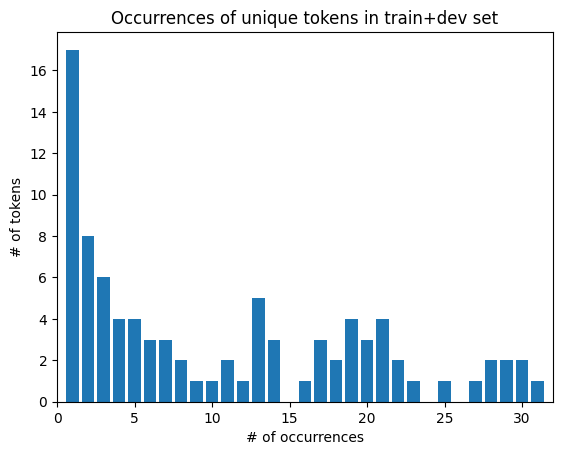

In [21]:
import matplotlib.pyplot as plt

plt.bar(x=TOKEN_COUNT_X, height=NUM_TOKENS_Y)
plt.title("Occurrences of unique tokens in train+dev set")
plt.xlabel("# of occurrences")
plt.ylabel("# of tokens")
plt.xlim(0, MAX_COUNT);

 As we can see above - nearly 18 tokens occur precisely once in the entire training corpus! Let's check a cumulative count of how many unique kanji exist with less than five occurrences throughout the corpus.

In [22]:
UNCOMMON_TOKENS_COUNT = 5

chars_with_infrequent_occurrence = set()
for count in range(1, UNCOMMON_TOKENS_COUNT + 1):
    if count in train_counts:
        token_list = train_counts[count]
        chars_with_infrequent_occurrence.update(set(token_list))

print(f"Number of tokens with <= {UNCOMMON_TOKENS_COUNT} occurrences : {len(chars_with_infrequent_occurrence)}")

Number of tokens with <= 5 occurrences : 32


#### Process special character tokens

There are several tokens which do not accurately correspond to an acoustic feature. A few examples are various commas and the period. Think of it this way, unless every sentence ends with a period (and this is uncommon - since training datasets are often comprised of small snippets of audio out of a longer conversations), then a model has insufficient context to determine when to end a sentence from just the snippet it was provided.

As such, we remove several special tokens such as commas, question marks, periods, quotation marks, and a few special tokens sometimes used in Vietnamese text.

In [23]:
import re
import unicodedata

# Vietnamese-specific characters to ignore
chars_to_ignore_regex = r'[,\?\.\!\-;:""""%\'…\{\}\[\]\(\)\<\>\~\®]'

def remove_special_characters(data):
    data["text"] = re.sub(chars_to_ignore_regex, '', data["text"]).lower().strip()
    return data

def normalize_vietnamese_characters(data):
    text = data["text"]
    text = unicodedata.normalize('NFC', text)  # Normalize to composed form
    data["text"] = text
    return data

def preprocess_vietnamese_text(data):
    data = remove_special_characters(data)
    data = normalize_vietnamese_characters(data)
    return data

####  Process dataset

Now that we have the functions necessary to clean up the transcripts, let's create a small pipeline to clean up the manifest and write new manifests for us. For simplicity's sake (as the dataset is so small), a simple sequential pipeline will be sufficient for our use case.

In [24]:
# Processing pipeline
def apply_preprocessors(manifest, preprocessors):
    for processor in preprocessors:
        for idx in tqdm(range(len(manifest)), desc=f"Applying {processor.__name__}"):
            manifest[idx] = processor(manifest[idx])

    print("Finished processing manifest!")
    return manifest

In [25]:
# List of pre-processing functions for Vietnamese
PREPROCESSORS = [
    remove_special_characters,
    normalize_vietnamese_characters
]

In [ ]:
# Load manifests
train_data = read_manifest(train_manifest)
dev_data = read_manifest(dev_manifest)
test_data = read_manifest(test_manifest)

# Apply preprocessing
train_data_processed = apply_preprocessors(train_data, PREPROCESSORS)
dev_data_processed = apply_preprocessors(dev_data, PREPROCESSORS)
test_data_processed = apply_preprocessors(test_data, PREPROCESSORS)

# Write new manifests
train_manifest_cleaned = write_processed_manifest(train_data_processed, train_manifest)
dev_manifest_cleaned = write_processed_manifest(dev_data_processed, dev_manifest)
test_manifest_cleaned = write_processed_manifest(test_data_processed, test_manifest)

#### Final character set

After pre-processing the dataset, let's recover the final character set used to train the models.

In [ ]:
train_manifest_data = read_manifest(train_manifest_cleaned)
train_charset = get_charset(train_manifest_data)

dev_manifest_data = read_manifest(dev_manifest_cleaned)
dev_charset = get_charset(dev_manifest_data)

train_dev_set = set.union(set(train_charset.keys()), set(dev_charset.keys()))

In [ ]:
char_model = nemo_asr.models.ASRModel.from_pretrained("stt_en_quartznet15x5", map_location='cuda')

#### Character Encoding CTC Model

Now that we have a processed dataset, we can begin training an ASR model on this dataset. The following section will detail how we prepare a CTC model which utilizes a Character Encoding scheme.

This section will utilize a pre-trained QuartzNet 15x5, which has been trained on roughly 7,000 hours of English speech base model. We will modify the decoder layer (thereby changing the model's vocabulary) and then train for a small number of epochs.

In [ ]:
char_model.change_vocabulary(new_vocabulary=list(train_dev_set))

#### Training on low resource languages

If the amount of training data or available computational resources are limited, it might be useful to freeze the encoder module of the network and train just the final decoder layer. This is also useful in cases where GPU memory is insufficient to train a large network, or cases where the model might overfit due to its size.

In cases where sufficient data is available - and "sufficient" is dependent on the complexity of the language - then it is advised to train the encoder as well to get the best possible transcript. When we say sufficient is relative to the language, we have noticed that some languages can obtain reasonable scores with a few hundred hours of transcribed speech, whereas some languages require several thousand hours.

It is also important to note that if the language remains the same, and some specific domain of text must be adapted for ASR, it is often easier to add a domain-specific language model to guide the generic ASR model than to attempt fine-tuning a full ASR model on limited data from that specific domain.

In [35]:
#@title Freeze Encoder { display-mode: "form" }
freeze_encoder = True #@param ["False", "True"] {type:"raw"}
freeze_encoder = bool(freeze_encoder)

#### Frozen Encoder - Unfrozen Batch Normalization

Freezing the encoder is generally helpful to limit computation and enable faster training; however, in many experiments, freezing the encoder in its entirety will often prevent a model from learning on low-resource languages.

In order to enable a frozen encoder model to learn on a new language stably, we, therefore, unfreeze the batch normalization layers in the encoder. 

On top of this, if the model contains "SqueezeExcite" sub-modules, we unfreeze them as well.In doing so, we notice that such models train properly and obtain respectable scores even on severely resource-limited languages.

Note: This phenomenon disappears when sufficient data is available (in such a case, the entire encoder can be trained as well). Therefore it is advised to unfreeze the encoder when sufficient data is available.

In [36]:
import torch
import torch.nn as nn

def enable_bn_se(m):
    if type(m) == nn.BatchNorm1d:
        m.train()
        for param in m.parameters():
            param.requires_grad_(True)

    if 'SqueezeExcite' in type(m).__name__:
        m.train()
        for param in m.parameters():
            param.requires_grad_(True)

In [37]:
if freeze_encoder:
  char_model.encoder.freeze()
  char_model.encoder.apply(enable_bn_se)
  logging.info("Model encoder has been frozen, and batch normalization has been unfrozen")
else:
  char_model.encoder.unfreeze()
  logging.info("Model encoder has been un-frozen")

[NeMo I 2024-10-07 08:41:42 705968631:4] Model encoder has been frozen, and batch normalization has been unfrozen


#### Update config

Each NeMo model has a config embedded in it, which can be accessed via model.cfg. In general, this is the config that was used to construct the model.For pre-trained models, this config generally represents the config used to construct the model when it was trained. A nice benefit to this embedded config is that we can repurpose it to set up new data loaders, optimizers, schedulers, and even data augmentation!

##### Updating the character set of the model

The most important step for preparing character encoding models for fine-tuning is to update the model's character set. Remember - the model was trained on some language with some specific dataset that had a certain character set. Character sets would rarely remain the same between training and fine-tuning (though it is still possible).

Each character encoding model has a model.cfg.labels attribute, which can be overridden via OmegaConf.

In [38]:
char_model.cfg.labels = list(train_dev_set)

 Now, we create a working copy of the model config and update it as needed.

In [39]:
cfg = copy.deepcopy(char_model.cfg)

#### Setting up data loaders

Now that the model's character set has been updated let's prepare the model to utilize the new character set even in the data loaders. Note that this is crucial so that the data produced during training/validation matches the new character set, and tokens are encoded/decoded correctly.

Note: An important config parameter is normalize_transcripts and parser. There are some parsers that are used for specific languages for character based models - currently only en is supported. These parsers will preprocess the text with the given languages parser. However, for other languages, it is advised to explicitly set normalize_transcripts = False - which will prevent the parser from processing text.

In [40]:
# Setup train, validation, test configs
with open_dict(cfg):
  # Train dataset  (Concatenate train manifest cleaned and dev manifest cleaned)
  cfg.train_ds.manifest_filepath = f"{train_manifest_cleaned},{dev_manifest_cleaned}"
  cfg.train_ds.labels = list(train_dev_set)
  cfg.train_ds.normalize_transcripts = False
  cfg.train_ds.batch_size = 32
  cfg.train_ds.num_workers = 8
  cfg.train_ds.pin_memory = True
  cfg.train_ds.trim_silence = True

  # Validation dataset  (Use test dataset as validation, since we train using train + dev)
  cfg.validation_ds.manifest_filepath = test_manifest_cleaned
  cfg.validation_ds.labels = list(train_dev_set)
  cfg.validation_ds.normalize_transcripts = False
  cfg.validation_ds.batch_size = 8
  cfg.validation_ds.num_workers = 8
  cfg.validation_ds.pin_memory = True
  cfg.validation_ds.trim_silence = True

In [41]:
# setup data loaders with new configs
char_model.setup_training_data(cfg.train_ds)
char_model.setup_multiple_validation_data(cfg.validation_ds)

[NeMo I 2024-10-07 08:42:09 collections:196] Dataset loaded with 2939 files totalling 3.52 hours
[NeMo I 2024-10-07 08:42:09 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-10-07 08:42:09 collections:196] Dataset loaded with 1274 files totalling 1.35 hours
[NeMo I 2024-10-07 08:42:09 collections:197] 0 files were filtered totalling 0.00 hours


####  Setting up optimizer and scheduler

When fine-tuning character models, it is generally advised to use a lower learning rate and reduced warmup. A reduced learning rate helps preserve the pre-trained weights of the encoder. Since the fine-tuning dataset is generally smaller than the original training dataset, the warmup steps would be far too much for the smaller fine-tuning dataset.


Note: When freezing the encoder, it is possible to use the original learning rate as the model was trained on. The original learning rate can be used because the encoder is frozen, so the learning rate is used only to optimize the decoder. However, a very high learning rate would still destabilize training, even with a frozen encoder.

In [42]:
# Original optimizer + scheduler
print(OmegaConf.to_yaml(char_model.cfg.optim))

name: novograd
lr: 0.01
betas:
- 0.8
- 0.5
weight_decay: 0.001
sched:
  name: CosineAnnealing
  warmup_steps: null
  warmup_ratio: null
  min_lr: 0.0
  last_epoch: -1



In [43]:
with open_dict(char_model.cfg.optim):
  char_model.cfg.optim.lr = 0.01
  char_model.cfg.optim.betas = [0.95, 0.5]  # from paper
  char_model.cfg.optim.weight_decay = 0.001  # Original weight decay
  char_model.cfg.optim.sched.warmup_steps = None  # Remove default number of steps of warmup
  char_model.cfg.optim.sched.warmup_ratio = 0.05  # 5 % warmup
  char_model.cfg.optim.sched.min_lr = 1e-5

#### Setting up augmentation

Remember that the model was trained on several thousands of hours of data, so the regularization provided to it might not suit the current dataset. We can easily change it as we see fit.

You might notice that we utilize char_model.from_config_dict() to create a new SpectrogramAugmentation object and assign it directly in place of the previous augmentation. This is generally the syntax to be followed whenever you notice a _target_ tag in the config of a model's inner config.

Note: For low resource languages, it might be better to increase augmentation via SpecAugment to reduce overfitting. However, this might, in turn, make it too hard for the model to train in a short number of epochs.

In [44]:
print(OmegaConf.to_yaml(char_model.cfg.spec_augment))

_target_: nemo.collections.asr.modules.SpectrogramAugmentation
rect_freq: 50
rect_masks: 5
rect_time: 120



#### Setup Metrics

Vietnamese uses the Latin alphabet (Quốc Ngữ) with additional diacritics. Unlike Japanese or Mandarin, Vietnamese does use spaces to separate words. Words are typically separated by spaces, similar to English. This means that Word Error Rate (WER) can be a meaningful metric for Vietnamese ASR systems. Given these characteristics we will use:

- (WER): Since Vietnamese uses spaces to separate words, WER can be an appropriate and meaningful metric. It will give you a good sense of how well your model is recognizing whole words.
- And we keep CER as a supplementary metric

In [45]:
 #@title Metric
use_wer = True #@param ["False", "True"] {type:"raw"}
use_cer = True #@param ["False", "True"] {type:"raw"}
log_prediction = True #@param ["False", "True"] {type:"raw"}

In [46]:
char_model.use_wer = use_wer
char_model.wer.use_cer = use_cer
char_model.wer.log_prediction = log_prediction

#### Setup Trainer and Experiment Manager

And that's it! Now we can train the model by simply using the Pytorch Lightning Trainer and NeMo Experiment Manager as always.For demonstration purposes, the number of epochs is kept intentionally low. Reasonable results can be obtained in around 100 epochs (approximately 20 minutes on an A100 GPUs).

In [47]:
import torch
import pytorch_lightning as ptl

if torch.cuda.is_available():
  accelerator = 'gpu'
else:
  accelerator = 'cpu'

EPOCHS = 100  # Higher epochs would provide better results, but would take hours to train

trainer = ptl.Trainer(devices=1,
                      accelerator=accelerator,
                      max_epochs=EPOCHS,
                      accumulate_grad_batches=1,
                      enable_checkpointing=False,
                      logger=False,
                      log_every_n_steps=5,
                      check_val_every_n_epoch=10)

# Setup model with the trainer
char_model.set_trainer(trainer)

# Finally, update the model's internal config
char_model.cfg = char_model._cfg

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [48]:
# Environment variable generally used for multi-node multi-gpu training.
# In notebook environments, this flag is unnecessary and can cause logs of multiple training runs to overwrite each other.
os.environ.pop('NEMO_EXPM_VERSION', None)

config = exp_manager.ExpManagerConfig(
    exp_dir=f'experiments/lang-{LANGUAGE}/',
    name=f"ASR-Char-Model-Language-{LANGUAGE}",
    checkpoint_callback_params=exp_manager.CallbackParams(
        monitor="val_wer",
        mode="min",
        always_save_nemo=True,
        save_best_model=True,
    ),
)

logger=False

config = OmegaConf.structured(config)

logdir = exp_manager.exp_manager(trainer, config)

[NeMo I 2024-10-07 08:44:32 exp_manager:396] Experiments will be logged at experiments/lang-vi/ASR-Char-Model-Language-vi/2024-10-07_08-44-32
[NeMo I 2024-10-07 08:44:32 exp_manager:856] TensorboardLogger has been set up


In [96]:
# %%time
# trainer.fit(char_model)

#### Results

Whether you trained for small number of epochs, the character word error rate
seems high (even after 100 epochs, CER is close to 68% or so on the test set).

The high WER (68%) indicates that the model's performance on Vietnamese ASR is not very good yet. Typically, for a well-performing ASR system, we'd want to see lower WER values, ideally below 20% or even lower for production-ready systems. 

This suggests that further optimization, more training data, and adjustments to the model architecture might be necessary to improve performance on Vietnamese ASR.Considering the limited amount of data available and the extensive vocabulary, this is expected to some degree.For reference, AISHELL datasets comprise some few hundred to one thousand hours of Mandarin speech to train roughly 5600 tokens, and those models are generally trained for a very long time on multi GPU setups.

In [51]:
save_path = f"Model-v1-{LANGUAGE}.nemo"
char_model.save_to(f"{save_path}")
print(f"Model saved at path : {os.getcwd() + os.path.sep + save_path}")

Model saved at path : /root/verb-workspace/Model-v1-vi.nemo


#### Testing

Below we show how to test an out of the box vietnamese audio, assuming .mp3 file format. Assuming the steps of training and saving the model in a similar notebook environment you can test the output as follows:

In [55]:
import nemo.collections.asr as nemo_asr
from pydub import AudioSegment # pip install pydub if not part of env
import os

# Function to convert MP3 to WAV format
def convert_mp3_to_wav(mp3_file, wav_file):
    audio = AudioSegment.from_mp3(mp3_file)
    audio.export(wav_file, format="wav")

# Path to the saved NeMo model
model_path = "/root/verb-workspace/Model-v1-vi.nemo"

# Load the saved ASR model
asr_model = nemo_asr.models.ASRModel.restore_from(model_path)
print(f"Model loaded from {model_path}")

# Path to your MP3 file in the root directory
mp3_file = 'OOB Data/FPTOpenSpeechData_Set002_V0.1_002090.mp3'  # Replace this with the actual file name of your MP3
wav_file = 'OOB Data WAV/FPTOpenSpeechData_Set001_V0.1_002090.wav'

# Convert MP3 to WAV
convert_mp3_to_wav(mp3_file, wav_file)
print(f"MP3 file converted to WAV: {wav_file}")

# Transcribe the WAV file using the ASR model
transcription = asr_model.transcribe([wav_file])

# Output the transcription
print(f"Transcription: {transcription[0]}")


[NeMo W 2024-10-07 09:35:31 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: datasets/vi/mozilla-foundation/common_voice_17_0/vi/train/train_mozilla-foundation_common_voice_17_0_manifest_processed.json,datasets/vi/mozilla-foundation/common_voice_17_0/vi/validation/validation_mozilla-foundation_common_voice_17_0_manifest_processed.json
    sample_rate: 16000
    labels:
    - ó
    - ệ
    - ò
    - è
    - ổ
    - i
    - ã
    - h
    - ớ
    - ờ
    - ố
    - ị
    - o
    - v
    - ý
    - p
    - a
    - ậ
    - ỡ
    - f
    - ả
    - ế
    - ù
    - ừ
    - ồ
    - ủ
    - ẫ
    - ỷ
    - ộ
    - b
    - â
    - s
    - k
    - ì
    - á
    - ẩ
    - é
    - l
    - ụ
    - ễ
    - ĩ
    - ô
    - e
    - u
    - ' '
    - t
    - d
    - ợ
    - ư
    - ẹ
    - 'y'
    - ẻ
    - ẽ
    - ă
    - ê
    - ằ


[NeMo I 2024-10-07 09:35:31 features:305] PADDING: 16
[NeMo I 2024-10-07 09:35:32 save_restore_connector:263] Model EncDecCTCModel was successfully restored from /root/verb-workspace/Model-v1-vi.nemo.
Model loaded from /root/verb-workspace/Model-v1-vi.nemo
MP3 file converted to WAV: OOB Data WAV/FPTOpenSpeechData_Set001_V0.1_002090.wav


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s]

Transcription: có đân nghiệp thang ngay phoật hờ thay đói nhắn là đến nhỉ khôn nhàn tâu tân


## Sub-word Encoding CTC Model

Sub-word encoding models are almost nearly identical to the Character encoding models. The primary difference lies in the fact that a sub-encoding model accepts a sub-word tokenized text corpus and emits sub-word tokens in its decoding step. The following section will detail how we prepare a CTC model which utilizes a sub-word Encoding scheme.

For this section, we will utilize a pre-trained Citrinet 512 trained on roughly 7,000 hours of English speech as the base model. We will modify the decoder layer (thereby changing the model's vocabulary) and then train for a small number of epochs.

##### Prepare Tokenizer

Before we update the vocabulary of the model, first, we need to construct a tokenizer. NeMo supports both Word Piece Tokenizer (via HuggingFace) or Sentence Piece Tokenizer (via Google SentencePiece library). We will utilize the SentencePiece tokenizer in this tutorial.

Preparation of the tokenizer is made simple by the process_asr_text_tokenizer.py script in NeMo. We will leverage this script to build the text corpus from the manifest directly, then create a tokenizer using that corpus.

Note: Ordinarily, for languages that have such substantially large vocabularies, there is no significant benefit obtained by constructing sub-word vocabulary. In Natural Language Processing, we could use enormous vocabulary sizes of 10,000+ tokens, but that is unfeasible for CTC loss training of ASR models.

Therefore, we will construct a sub-word tokenizer with vocabulary size exactly the same as the character encoding model plus add a few tokens required by SentencePiece required to perform tokenization. You can experiment with the effect of larger vocabularies by editing VOCAB_SIZE below.

In [56]:
if not os.path.exists("scripts/process_asr_text_tokenizer.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/tokenizers/process_asr_text_tokenizer.py

--2024-10-07 10:10:01--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/tokenizers/process_asr_text_tokenizer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16631 (16K) [text/plain]
Saving to: ‘scripts/process_asr_text_tokenizer.py’

process_asr_text_to 100%[===================>]  16.24K  --.-KB/s    in 0s      

2024-10-07 10:10:02 (80.7 MB/s) - ‘scripts/process_asr_text_tokenizer.py’ saved [16631/16631]



In [57]:
#@title Tokenizer Config { display-mode: "form" }
TOKENIZER_TYPE = "bpe" #@param ["bpe", "unigram"]

 You might wonder, why do we need len(train_dev_set) + 2 as the minimumVOCAB_SIZE. The answer is that we are utilizing the SentencePiece implementation of the Byte Pair Tokenization algorithm.In this case, the byte piece tokenizer requires at least two tokens -  and _. SentencePiece represents  using the ⁇ token.

In [58]:
# << VOCAB SIZE can be changed to any value larger than (len(train_dev_set) + 2)! >>
VOCAB_SIZE = len(train_dev_set) + 2

In [59]:
!python scripts/process_asr_text_tokenizer.py \
  --manifest=$train_manifest_cleaned,$dev_manifest_cleaned \
  --vocab_size=$VOCAB_SIZE \
  --data_root=$tokenizer_dir \
  --tokenizer="spe" \
  --spe_type=$TOKENIZER_TYPE \
  --spe_character_coverage=1.0 \
  --no_lower_case \
  --log

INFO:root:Finished extracting manifest : datasets/vi/mozilla-foundation/common_voice_17_0/vi/train/train_mozilla-foundation_common_voice_17_0_manifest_processed.json
INFO:root:Finished extracting manifest : datasets/vi/mozilla-foundation/common_voice_17_0/vi/validation/validation_mozilla-foundation_common_voice_17_0_manifest_processed.json
INFO:root:Finished extracting all manifests ! Number of sentences : 2939
[NeMo I 2024-10-07 10:10:44 sentencepiece_tokenizer:317] Processing tokenizers/vi/text_corpus/document.txt and store at tokenizers/vi/tokenizer_spe_bpe_v93
sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=tokenizers/vi/text_corpus/document.txt --model_prefix=tokenizers/vi/tokenizer_spe_bpe_v93/tokenizer --vocab_size=93 --shuffle_input_sentence=true --hard_vocab_limit=false --model_type=bpe --character_coverage=1.0 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: tokenizers/vi/text_corpus/document.txt
 

In [60]:
TOKENIZER_DIR = f"{tokenizer_dir}/tokenizer_spe_{TOKENIZER_TYPE}_v{VOCAB_SIZE}/"
print("Tokenizer directory :", TOKENIZER_DIR)

Tokenizer directory : tokenizers/vi/tokenizer_spe_bpe_v93/


When using the unigram tokenizer, for certain languages, it is possible to request a tokenizer vocab size larger than the number of unique unigram subwords that can be built from the text corpus.

This happens more frequently in low-resource languages where a very small number of transcripts exist.So we perform a check, asserting that the number of tokens in the vocabulary is >= the VOCAB_SIZE.

In [61]:
 # Number of tokens in tokenizer -
with open(os.path.join(TOKENIZER_DIR, 'tokenizer.vocab')) as f:
  tokens = f.readlines()

num_tokens = len(tokens)
print("Number of tokens : ", num_tokens)

Number of tokens :  93


In [62]:
if num_tokens < VOCAB_SIZE:
    print(
        f"The text in this dataset is too small to construct a tokenizer "
        f"with vocab size = {VOCAB_SIZE}. Current number of tokens = {num_tokens}. "
        f"Please reconstruct the tokenizer with fewer tokens"
    )

#### Load pre-trained model

In [63]:
model = nemo_asr.models.ASRModel.from_pretrained("stt_en_citrinet_512", map_location='cuda')

[NeMo I 2024-10-07 10:11:32 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_citrinet_512/versions/1.0.0rc1/files/stt_en_citrinet_512.nemo to /root/.cache/torch/NeMo/NeMo_2.0.0rc0/stt_en_citrinet_512/3262321355385bb7cf5a583146117d77/stt_en_citrinet_512.nemo
[NeMo I 2024-10-07 10:11:39 common:815] Instantiating model from pre-trained checkpoint
[NeMo I 2024-10-07 10:11:41 mixins:172] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2024-10-07 10:11:42 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    
[NeMo W 2024-10-07 10:11:42 modelPT:183] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    
[NeMo W 2024-10-07 10:11:42 modelPT:189] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a valid configuration file to setup the test data loader(s).
    T

[NeMo I 2024-10-07 10:11:42 features:305] PADDING: 16
[NeMo I 2024-10-07 10:11:43 save_restore_connector:263] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_2.0.0rc0/stt_en_citrinet_512/3262321355385bb7cf5a583146117d77/stt_en_citrinet_512.nemo.


####  Preserving decoder initialization for sub-word models

In [64]:
# Preserve the decoder parameters in case weight matching can be done later
pretrained_decoder = model.decoder.state_dict()

#### Update the vocabulary

Changing the vocabulary of a sub-word encoding ASR model is as simple as passing the path of the tokenizer dir to change_vocabulary().

In [65]:
model.change_vocabulary(new_tokenizer_dir=TOKENIZER_DIR, new_tokenizer_type="bpe") 

[NeMo W 2024-10-07 10:12:11 modelPT:272] You tried to register an artifact under config key=tokenizer.model_path but an artifact for it has already been registered.
[NeMo W 2024-10-07 10:12:11 modelPT:272] You tried to register an artifact under config key=tokenizer.vocab_path but an artifact for it has already been registered.


[NeMo I 2024-10-07 10:12:11 mixins:172] Tokenizer SentencePieceTokenizer initialized with 93 tokens
[NeMo I 2024-10-07 10:12:11 ctc_bpe_models:265] 
    Replacing old number of classes (1024) with new number of classes - 93
[NeMo I 2024-10-07 10:12:12 ctc_bpe_models:307] Changed tokenizer to ['<unk>', '▁c', '▁', 'n', 'h', 'i', 't', 'c', 'g', 'm', 'a', 'đ', 'à', 'u', 'o', 'l', 'y', 'r', 'ư', 'b', 'ô', 'v', 'k', 'ó', 'á', 's', 'ế', 'ì', 'ạ', 'ờ', 'p', 'ả', 'ấ', 'ê', 'e', 'ớ', 'â', 'ề', 'ộ', 'ố', 'ơ', 'ồ', 'q', 'ợ', 'ậ', 'ủ', 'x', 'd', 'ú', 'ắ', 'ầ', 'ệ', 'ò', 'ể', 'ã', 'ở', 'ứ', 'ẹ', 'ọ', 'ữ', 'ị', 'ũ', 'ừ', 'í', 'ặ', 'é', 'ă', 'ỏ', 'ù', 'ỉ', 'ẽ', 'ẫ', 'ự', 'ỗ', 'ử', 'ổ', 'ụ', 'ằ', 'ĩ', 'ẳ', 'ẻ', 'è', 'ý', 'ẩ', 'ỡ', 'ỷ', 'õ', 'ỳ', 'ễ', 'f', 'ỵ', 'ẵ', 'ỹ'] vocabulary.


####  Restore decoder weights (if possible)

If the new vocabulary size matches the old vocabulary size, it is possible to restore the decoder weights in addition to the encoder weights.The following snippet checks the weight shapes and then attempts to restore the parameters of the decoder.

In [66]:
# Insert preserved model weights if shapes match
if model.decoder.decoder_layers[0].weight.shape == pretrained_decoder['decoder_layers.0.weight'].shape:
    model.decoder.load_state_dict(pretrained_decoder)
    logging.info("Decoder shapes matched - restored weights from pre-trained model")
else:
    logging.info("\nDecoder shapes did not match - could not restore decoder weights from pre-trained model.")

[NeMo I 2024-10-07 10:12:28 965178770:6] 
    Decoder shapes did not match - could not restore decoder weights from pre-trained model.


 Similar to the Character-based models, we can freeze the encoder and unfreeze the batch normalization layers if the dataset is tiny.

In [67]:
#@title Freeze Encoder { display-mode: "form" }
freeze_encoder = True #@param ["False", "True"] {type:"raw"}
freeze_encoder = bool(freeze_encoder)

In [68]:
if freeze_encoder:
  model.encoder.freeze()
  model.encoder.apply(enable_bn_se)
  logging.info("Model encoder has been frozen")
else:
  model.encoder.unfreeze()
  logging.info("Model encoder has been un-frozen")

[NeMo I 2024-10-07 10:12:54 2799607833:4] Model encoder has been frozen


In [69]:
cfg = copy.deepcopy(model.cfg)

In [70]:
# Setup new tokenizer
cfg.tokenizer.dir = TOKENIZER_DIR
cfg.tokenizer.type = "bpe"

# Set tokenizer config
model.cfg.tokenizer = cfg.tokenizer

####  Setup data loaders

While significant sections remain the same between character-based and sub-word-based model configs - the data loaders are the main area where they diverge.

The sub-word encoding models do not require a "model.cfg.labels" section. In fact, their data loaders do not require labels at all! The labels are automatically extracted from the provided tokenizer, and the data loaders and updated implicitly.

In [71]:
# Setup train/val/test configs
print(OmegaConf.to_yaml(cfg.train_ds))

manifest_filepath: null
sample_rate: 16000
batch_size: 32
trim_silence: true
max_duration: 16.7
shuffle: true
is_tarred: false
tarred_audio_filepaths: null



In [72]:
# Setup train, validation, test configs
with open_dict(cfg):
  # Train dataset
  cfg.train_ds.manifest_filepath = f"{train_manifest_cleaned},{dev_manifest_cleaned}"
  cfg.train_ds.batch_size = 32
  cfg.train_ds.num_workers = 8
  cfg.train_ds.pin_memory = True
  cfg.train_ds.use_start_end_token = True
  cfg.train_ds.trim_silence = True

  # Validation dataset
  cfg.validation_ds.manifest_filepath = test_manifest_cleaned
  cfg.validation_ds.batch_size = 8
  cfg.validation_ds.num_workers = 8
  cfg.validation_ds.pin_memory = True
  cfg.validation_ds.use_start_end_token = True
  cfg.validation_ds.trim_silence = True

  # Test dataset
  cfg.test_ds.manifest_filepath = test_manifest_cleaned
  cfg.test_ds.batch_size = 8
  cfg.test_ds.num_workers = 8
  cfg.test_ds.pin_memory = True
  cfg.test_ds.use_start_end_token = True
  cfg.test_ds.trim_silence = True

In [73]:
# setup model with new configs
model.setup_training_data(cfg.train_ds)
model.setup_multiple_validation_data(cfg.validation_ds)
model.setup_multiple_test_data(cfg.test_ds)

[NeMo I 2024-10-07 10:13:32 collections:196] Dataset loaded with 2939 files totalling 3.52 hours
[NeMo I 2024-10-07 10:13:32 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-10-07 10:13:33 collections:196] Dataset loaded with 1274 files totalling 1.35 hours
[NeMo I 2024-10-07 10:13:33 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-10-07 10:13:33 collections:196] Dataset loaded with 1274 files totalling 1.35 hours
[NeMo I 2024-10-07 10:13:33 collections:197] 0 files were filtered totalling 0.00 hours


#### Examine dataset outliers

In general, there are minor differences between the Character encoding and Sub-word encoding models. Since sub-words can encode larger sequence of tokens into a single subword, they substantially reduce the target sequence length.Citrinet takes advantage of this reduction by aggressively downsampling the input three times (a total of 8x downsampling). At this level of downsampling, it is possible to encounter a specific limitation of CTC loss.

In [74]:
def analyse_ctc_failures_in_model(model):
    count_ctc_failures = 0
    am_seq_lengths = []
    target_seq_lengths = []

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)
    mode = model.training

    train_dl = model.train_dataloader()

    with torch.no_grad():
      model = model.eval()
      for batch in tqdm(train_dl, desc='Checking for CTC failures'):
          x, x_len, y, y_len = batch
          x, x_len = x.to(device), x_len.to(device)
          x_logprobs, x_len, greedy_predictions = model(input_signal=x, input_signal_length=x_len)

          # Find how many CTC loss computation failures will occur
          for xl, yl in zip(x_len, y_len):
              if xl <= yl:
                  count_ctc_failures += 1

          # Record acoustic model lengths=
          am_seq_lengths.extend(x_len.to('cpu').numpy().tolist())

          # Record target sequence lengths
          target_seq_lengths.extend(y_len.to('cpu').numpy().tolist())

          del x, x_len, y, y_len, x_logprobs, greedy_predictions

    if mode:
      model = model.train()

    return count_ctc_failures, am_seq_lengths, target_seq_lengths

In [ ]:
results = analyse_ctc_failures_in_model(model)

In [77]:
num_ctc_failures, am_seq_lengths, target_seq_lengths = results

In [78]:
if num_ctc_failures > 0:
  logging.warning(f"\nCTC loss will fail for {num_ctc_failures} samples ({num_ctc_failures * 100./ float(len(am_seq_lengths))} % of samples)!\n"
                  f"Increase the vocabulary size of the tokenizer so that this number becomes close to zero !")
else:
  logging.info("No CTC failure cases !")

[NeMo W 2024-10-07 10:14:21 877355761:2] 
    CTC loss will fail for 228 samples (7.757740728138823 % of samples)!
    Increase the vocabulary size of the tokenizer so that this number becomes close to zero !


In [79]:
# Compute average ratio of T / U
avg_T = sum(am_seq_lengths) / float(len(am_seq_lengths))
avg_U = sum(target_seq_lengths) / float(len(target_seq_lengths))

avg_length_ratio = 0
for am_len, tgt_len in zip(am_seq_lengths, target_seq_lengths):
  avg_length_ratio += (am_len / float(tgt_len))
avg_length_ratio = avg_length_ratio / len(am_seq_lengths)

print(f"Average Acoustic model sequence length = {avg_T}")
print(f"Average Target sequence length = {avg_U}")
print()
print(f"Ratio of Average AM sequence length to target sequence length = {avg_length_ratio}")

Average Acoustic model sequence length = 52.13235794487921
Average Target sequence length = 30.823069071112624

Ratio of Average AM sequence length to target sequence length = 1.8784254358110515


#### Setup optimizer and scheduler

Similar to the character encoding model, we slightly reduce the learning rate when fine-tuning.

In [80]:
print(OmegaConf.to_yaml(cfg.optim))

name: novograd
lr: 0.05
betas:
- 0.8
- 0.25
weight_decay: 0.001
sched:
  name: CosineAnnealing
  warmup_steps: 1000
  warmup_ratio: null
  min_lr: 1.0e-09
  last_epoch: -1



####  Setup data augmentation

We also increase the SpecAugment masks to prevent overfitting (since it is a larger model).

In [81]:
with open_dict(model.cfg.optim):
  model.cfg.optim.lr = 0.025
  model.cfg.optim.weight_decay = 0.001
  model.cfg.optim.sched.warmup_steps = None  # Remove default number of steps of warmup
  model.cfg.optim.sched.warmup_ratio = 0.10  # 10 % warmup
  model.cfg.optim.sched.min_lr = 1e-9

In [82]:
with open_dict(model.cfg.spec_augment):
  model.cfg.spec_augment.freq_masks = 2
  model.cfg.spec_augment.freq_width = 25
  model.cfg.spec_augment.time_masks = 10
  model.cfg.spec_augment.time_width = 0.05

model.spec_augmentation = model.from_config_dict(model.cfg.spec_augment)

####  Setup Metrics

In [90]:
#@title Metric
use_cer = True #@param ["False", "True"] {type:"raw"}
log_prediction = True #@param ["False", "True"] {type:"raw"}

In [91]:
model.wer.use_cer = use_cer
model.wer.log_prediction = log_prediction

#### Setup Trainer and Experiment Manager

And that's it! Now we can train the model by simply using the Pytorch Lightning Trainer and NeMo Experiment Manager as always.For demonstration purposes, the number of epochs can be reduced. Reasonable results can be obtained in around 100 epochs

In [92]:
import torch
import pytorch_lightning as ptl

if torch.cuda.is_available():
  accelerator = 'gpu'
else:
  accelerator = 'cpu'

EPOCHS = 100

trainer = ptl.Trainer(devices=1,
                      accelerator=accelerator,
                      max_epochs=EPOCHS,
                      accumulate_grad_batches=1,
                      enable_checkpointing=False,
                      logger=False,
                      log_every_n_steps=5,
                      check_val_every_n_epoch=10)

# Setup model with the trainer
model.set_trainer(trainer)

# finally, update the model's internal config
model.cfg = model._cfg

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [93]:
from nemo.utils import exp_manager

# Environment variable generally used for multi-node multi-gpu training.
# In notebook environments, this flag is unnecessary and can cause logs of multiple training runs to overwrite each other.
os.environ.pop('NEMO_EXPM_VERSION', None)

config = exp_manager.ExpManagerConfig(
    exp_dir=f'experiments/lang-{LANGUAGE}/',
    name=f"ASR-Model-Language-{LANGUAGE}",
    checkpoint_callback_params=exp_manager.CallbackParams(
        monitor="val_wer",
        mode="min",
        always_save_nemo=True,
        save_best_model=True,
    ),
)

config = OmegaConf.structured(config)

logdir = exp_manager.exp_manager(trainer, config)

[NeMo I 2024-10-07 10:18:52 exp_manager:396] Experiments will be logged at experiments/lang-vi/ASR-Model-Language-vi/2024-10-07_10-18-52
[NeMo I 2024-10-07 10:18:52 exp_manager:856] TensorboardLogger has been set up


In [99]:
# %%time
# trainer.fit(model)

In [95]:
save_path = f"Model-{LANGUAGE}.nemo"
model.save_to(f"{save_path}")
print(f"Model saved at path : {os.getcwd() + os.path.sep + save_path}")

Model saved at path : /root/verb-workspace/Model-vi.nemo


#### Testing

Follow the same example and simply change paths to test on your own data the transcription.

In [98]:
import nemo.collections.asr as nemo_asr
from pydub import AudioSegment
import os

# Function to convert MP3 to WAV format
def convert_mp3_to_wav(mp3_file, wav_file):
    audio = AudioSegment.from_mp3(mp3_file)
    audio.export(wav_file, format="wav")

# Path to the saved NeMo model
model_path = "/root/verb-workspace/Model-vi.nemo"

# Load the saved ASR model
asr_model = nemo_asr.models.ASRModel.restore_from(model_path)
print(f"Model loaded from {model_path}")

# Path to your MP3 file in the root directory
mp3_file = 'OOB Data/FPTOpenSpeechData_Set002_V0.1_002082.mp3'  # Replace this with the actual file name of your MP3
wav_file = 'OOB Data WAV/FPTOpenSpeechData_Set001_V0.1_002082.wav'

# Convert MP3 to WAV
convert_mp3_to_wav(mp3_file, wav_file)
print(f"MP3 file converted to WAV: {wav_file}")

# Transcribe the WAV file using the ASR model
transcription = asr_model.transcribe([wav_file])

# Output the transcription
print(f"Transcription: {transcription[0]}")


[NeMo I 2024-10-07 10:43:53 mixins:172] Tokenizer SentencePieceTokenizer initialized with 93 tokens


[NeMo W 2024-10-07 10:43:53 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: datasets/vi/mozilla-foundation/common_voice_17_0/vi/train/train_mozilla-foundation_common_voice_17_0_manifest_processed.json,datasets/vi/mozilla-foundation/common_voice_17_0/vi/validation/validation_mozilla-foundation_common_voice_17_0_manifest_processed.json
    sample_rate: 16000
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    num_workers: 8
    pin_memory: true
    use_start_end_token: true
    
[NeMo W 2024-10-07 10:43:53 modelPT:183] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 


[NeMo I 2024-10-07 10:43:53 features:305] PADDING: 16
[NeMo I 2024-10-07 10:43:54 save_restore_connector:263] Model EncDecCTCModelBPE was successfully restored from /root/verb-workspace/Model-vi.nemo.
Model loaded from /root/verb-workspace/Model-vi.nemo
MP3 file converted to WAV: OOB Data WAV/FPTOpenSpeechData_Set001_V0.1_002082.wav



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]

Transcription: tó những làn hông nưới táo hang ấyđ


#### Conclusion


This tutorial discussed the generic steps to prepare a dataset in a different language, prepared two models for fine-tuning, and discussed some additional insights for fine-tuning CTC-based models.

While the focus was on a small dataset for Vietnamese, nearly all of this information can be used for larger datasets and other scenarios where data is limited, or the model's size prevents fine-tuning the entire model.